# Smart Budget Planner
Data Prepared by Raphael Lu and Jeel Faldu

In [1]:
import pandas as pd
import numpy as np
import json
import statistics
import matplotlib.pyplot as plt
import plotly.express as px


import kagglehub
from kagglehub import KaggleDatasetAdapter

pd.set_option('display.float_format', '{:.2f}'.format)  #diplays numbers in decimal v sci notation

## Introduction

The purpose of this project is to prepare data for the **Smart Budget Planner** — a collaborative app that helps users understand their spending patterns compared to national averages.

This notebook focuses on the **Data Science** component of the project.  
We use a Kaggle dataset containing international customer credit card transactions from **October 1 to October 30, 2024**.

The goal is to transform the raw transaction data into **cleaned, aggregated, and benchmarked insights** that power the frontend budgeting app.

This notebook walks through the complete workflow — from data cleaning and transformation to generating final **JSON outputs** that are integrated by the **Software Engineering** team into the Smart Budget Planner application.


## Data Loading and Pre-processing

### Historic Currency Conversion Rates

During data exploration, it was found that multiple customers made foreign transaction. The dictionary below was obtain with the use of Claude.

**Currency Conversion Rates**  
Source: HM Revenue & Customs (HMRC) - October 2024 Monthly Exchange Rates
Retrieved via: Claude AI (Anthropic) web search on November 9, 2025
Original source: https://www.trade-tariff.service.gov.uk/exchange_rates/view/2024-10
Date Range: October 1-31, 2024

In [2]:
conversion_to_usd = {
    'USA': 1.0,
    'UK': 0.757,        # 1 GBP = 1.32 USD → 1 USD = 0.757 GBP
    'Brazil': 0.182,    # BRL: 7.24 per GBP → 5.48 per USD
    'Japan': 0.00706,   # JPY: 187.4 per GBP → 141.8 per USD
    'Australia': 0.679, # AUD: 1.95 per GBP → 1.47 per USD
    'Nigeria': 0.00061, # NGN: 2165.7 per GBP → 1639 per USD
    'Germany': 0.842,   # EUR: 1.19 per GBP → 1.09 EUR per USD
    'Mexico': 0.0524,   # MXN: 25.21 per GBP → 19.08 per USD
    'Russia': 0.0109,   # RUB: 121.3 per GBP → 91.8 per USD
    'France': 0.842,    # EUR (same as Germany)
    'Canada': 0.736,    # CAD: 1.79 per GBP → 1.36 per USD
    'Singapore': 0.773  # SGD: 1.71 per GBP → 1.29 per USD
}

denom_dict = {
    'USD': 1.0,
    'GBP': 0.757,
    'BRL': 0.182,
    'JPY': 0.00706,
    'AUD': 0.679,
    'NGN': 0.00061,
    'EUR': 0.842,
    'MXN': 0.0524,
    'RUB': 0.0109,
    'CAD': 0.736,
    'SGD': 0.773
}

country_to_currency = {
    'USA': 'USD',
    'UK': 'GBP',
    'Brazil': 'BRL',
    'Japan': 'JPY',
    'Australia': 'AUD',
    'Nigeria': 'NGN',
    'Germany': 'EUR',
    'Mexico': 'MXN',
    'Russia': 'RUB',
    'France': 'EUR',
    'Canada': 'CAD',
    'Singapore': 'SGD'
}

### df Loading

In [ ]:
# Load the dataset from Kaggle
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                            "ismetsemedov/transactions",
                            "synthetic_fraud_data.csv")

100%|██████████| 2.73G/2.73G [02:54<00:00, 16.8MB/s]


In [ ]:
# Display the first few rows of the dataset
df.head(6)

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True
5,TX_7fb62ea6,CUST_55630,6771346275824473,2024-09-30 00:00:03.050458+00:00,Education,online,Coursera,11.76,BRL,Brazil,...,Chrome,web,f79b73f19703d83fbfc2736f24cb108c,184.56.130.84,1,False,0,False,"{'num_transactions': 1130, 'total_amount': 695...",True


In [ ]:
# Display the information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   transaction_id       object 
 1   customer_id          object 
 2   card_number          int64  
 3   timestamp            object 
 4   merchant_category    object 
 5   merchant_type        object 
 6   merchant             object 
 7   amount               float64
 8   currency             object 
 9   country              object 
 10  city                 object 
 11  city_size            object 
 12  card_type            object 
 13  card_present         bool   
 14  device               object 
 15  channel              object 
 16  device_fingerprint   object 
 17  ip_address           object 
 18  distance_from_home   int64  
 19  high_risk_merchant   bool   
 20  transaction_hour     int64  
 21  weekend_transaction  bool   
 22  velocity_last_hour   object 
 23  is_fraud             bool   
dty

In [ ]:
# Display the unique values in each column
print('Unique Categories:', df['merchant_category'].unique())
print()
print('Unique Merchant Types (sub catagories):', df['merchant_type'].unique())
print()
print('Unique Countries:', df['country'].unique())
print()
print('Unique Currencies:', df['currency'].unique())

Unique Categories: ['Restaurant' 'Entertainment' 'Grocery' 'Gas' 'Healthcare' 'Education'
 'Travel' 'Retail']

Unique Merchant Types (sub catagories): ['fast_food' 'gaming' 'physical' 'major' 'medical' 'online' 'hotels'
 'pharmacy' 'premium' 'events' 'supplies' 'airlines' 'local' 'booking'
 'streaming' 'transport' 'casual']

Unique Countries: ['UK' 'Brazil' 'Japan' 'Australia' 'Nigeria' 'Germany' 'Mexico' 'Russia'
 'France' 'Canada' 'Singapore' 'USA']

Unique Currencies: ['GBP' 'BRL' 'JPY' 'AUD' 'NGN' 'EUR' 'MXN' 'RUB' 'CAD' 'SGD' 'USD']


### Drop Irrelevant Columns

In [7]:
# Drop Fraud Cases
df = df[df['is_fraud'] == False]

# Cols to drop
drop_cols = ['card_number', 'city_size', 'card_type', 'card_present',
             'device_fingerprint', 'ip_address',
             'high_risk_merchant','velocity_last_hour','device','is_fraud',
             'transaction_hour','city']

### Create Transactions df

In [ ]:
# Create a new DataFrame with the specified columns dropped
df_transactions = df.copy().drop(drop_cols, axis=1)
df_transactions

,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction
0,TX_a0ad2a2a,CUST_72886,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,mobile,0,False
2,TX_a9461c6d,CUST_10715,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,web,0,False
3,TX_7be21fc4,CUST_16193,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,mobile,0,False
6,TX_e0d7eb37,CUST_89147,2024-09-30 00:00:03.149440+00:00,Grocery,online,Instacart,2606.19,BRL,Brazil,mobile,0,False
7,TX_eb55c2be,CUST_10150,2024-09-30 00:00:06.295911+00:00,Travel,hotels,Westin,828.33,EUR,Germany,web,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7483761,TX_58a762fa,CUST_11344,2024-10-30 23:59:58.926575+00:00,Retail,online,AliExpress,887.32,SGD,Singapore,web,0,False
7483762,TX_dabcf671,CUST_38961,2024-10-30 23:59:58.950801+00:00,Grocery,physical,Kroger,356.06,EUR,France,web,0,False
7483763,TX_ab567eb4,CUST_75576,2024-10-30 23:59:58.972155+00:00,Grocery,physical,Kroger,391.96,SGD,Singapore,web,0,False
7483764,TX_5ae61846,CUST_82508,2024-10-30 23:59:58.996608+00:00,Retail,online,eBay,601.71,USD,USA,web,0,False


### Drop Duplicate Columns

In [ ]:
# Remove duplicates based on 'customer_id' and 'transaction_id'
df_transactions.drop_duplicates(subset=['customer_id', 'transaction_id'], inplace=True)

After loading the dataset, and converting the currencies, We then removed fraudulent transactions to focus only on legitimate spending behavior. To streamline the analysis, we dropped irrelevant columns such as device details, city information, and fraud-related metadata, creating a cleaner DataFrame (df_transactions) that contains only essential features needed for the Smart Budget Planner’s spending analysis.

### Timestamp Processing

Data were collected from 30 Sept through 30 October. For calander month represensation, September transactions were dropped from the dataset.

In [ ]:
# Convert the 'timestamp' column to datetime format
df_transactions['timestamp'] = pd.to_datetime(df_transactions['timestamp'], format='mixed')

In [ ]:
# Display the minimum and maximum timestamps in the dataset
df_transactions['timestamp'].min(), df_transactions['timestamp'].max()

(Timestamp('2024-09-30 00:00:01.034820+0000', tz='UTC'),
 Timestamp('2024-10-30 23:59:59.101885+0000', tz='UTC'))

In [ ]:
# Create a new column 'date_transact' with the date in 'dd-mm-yyyy' format
df_transactions['date_transact'] = df_transactions['timestamp'].dt.strftime('%d-%m-%Y')

In [ ]:
# Convert 'date_transact' to datetime format and filter out transactions from September
df_transactions['date_transact'] = pd.to_datetime(df_transactions['date_transact'], dayfirst=True)
df_transactions = df_transactions[df_transactions['date_transact'].dt.month != 9].copy()

df_transactions['date_transact'] = df_transactions['date_transact'].dt.strftime('%Y-%m-%d')
df_transactions.drop('timestamp', axis = 1)
display(df_transactions.head(3))


,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction,date_transact
240937,TX_26fcd971,CUST_82404,2024-10-01 00:00:00.771360+00:00,Grocery,physical,Kroger,146.82,AUD,Australia,mobile,0,False,2024-10-01
240938,TX_72acc22e,CUST_94778,2024-10-01 00:00:01.466583+00:00,Retail,physical,Target,2246.80,BRL,Brazil,web,0,False,2024-10-01
240939,TX_618e4c2e,CUST_67481,2024-10-01 00:00:02.210550+00:00,Retail,physical,Costco,1750.32,SGD,Singapore,mobile,0,False,2024-10-01


### Categories and Sub-categories

In [ ]:
# Display the unique merchant types for each merchant category
for cat in df_transactions['merchant_category'].unique():
  mask = df_transactions['merchant_category'] == cat
  print(f'Sub Categories in {cat}', df_transactions[mask]['merchant_type'].unique())
  print()

Sub Categories in Grocery ['physical' 'online']

Sub Categories in Retail ['physical' 'online']

Sub Categories in Restaurant ['fast_food' 'casual' 'premium']

Sub Categories in Gas ['local' 'major']

Sub Categories in Entertainment ['events' 'gaming' 'streaming']

Sub Categories in Healthcare ['medical' 'pharmacy']

Sub Categories in Education ['online' 'supplies']

Sub Categories in Travel ['transport' 'hotels' 'booking' 'airlines']



After creating the cleaned transaction dataset, we processed the timestamps to ensure temporal consistency. Since the raw data included transactions from September 30 to October 30, 2024, we retained only October transactions for accurate monthly analysis. The timestamp column was converted to datetime format, and a new `date_transact` column was created in standardized `YYYY-MM-DD` format for easier grouping and visualization. We then examined merchant categories and their corresponding sub-categories, helping us understand the spending structure across different types of merchants and laying the groundwork for later aggregation and benchmarking steps.

## Noted Data Irregularity

When looking a all transactions made in the USA, total October spending was distributed as
- count: 4869
- mean:      \$49,444.40
- std:      \$157,870.52
- min:         **\$145.89**
- 50%:        **\$8,632.44**
- max:     \$1,674,076.82

However, when looking at transactions made in the USA, with `'distance_from_home' == 0` (presumed US based shoppers), the total October spending was distributed as:
- count: 382
- mean:      \$506,713.52
- std:      \$157,870.52
- min:         **\$163,212.85**
- 50%:        **\$424,368.83**
- max:     \$1,674,076.82

Given that the std. is unchanged across both samples, these 382 cases skew/obscure the data.

For the purpose of this project (and given that we are working with syntheic data), we determined that these 382 select cases do not reflect typical customer usage.

Specifically, given the number of suposed domestic users (n= 382) versus international (n=4869) and montly spending at the 25th%-tile for the so-called 'domestic' users was $290,005.62, we assumed an error in the data documentaion.

In a real world scenario, we would interrogate this issue with the data procurement team.

**Processing**:
- Boolean values for `distance_from_home` were swapped 0 <--> 1
- Accounting for currency conversions, users who spent a monthly today at or >75th%-tile were dropped from the dataset (seen later in notebook)

In [ ]:
# Calculate the total amount spent by each customer in the USA and for transactions made from home in the USA
usa_transaction_mask = (df_transactions['country'] == 'USA')
home_usa_mask = (df_transactions['country'] == 'USA') & (df_transactions['distance_from_home'] == 0)

test_stats_1 = df_transactions[usa_transaction_mask].groupby('customer_id')['amount'].sum().describe()
test_stats_2 = df_transactions[home_usa_mask].groupby('customer_id')['amount'].sum().describe()

test_stats_1, test_stats_2

(count      4869.00
 mean      47865.89
 std      152900.71
 min         145.89
 25%        4675.58
 50%        8338.80
 75%       15291.47
 max     1612783.45
 Name: amount, dtype: float64,
 count       382.00
 mean     490639.46
 std      289666.24
 min      156997.27
 25%      290005.62
 50%      413465.74
 75%      572514.11
 max     1612783.45
 Name: amount, dtype: float64)

#### Similar irregular patterns seen in Mexico and Canada data

In [ ]:
# Calculate the total amount spent by each customer in Mexico and for transactions made from home in Mexico
mex_transaction_mask = (df_transactions['country'] == 'Mexico')
home_mex_mask = (df_transactions['country'] == 'Mexico') & (df_transactions['distance_from_home'] == 0)

test_stats_1 = df_transactions[mex_transaction_mask].groupby('customer_id')['amount'].sum().describe()
test_stats_2 = df_transactions[home_mex_mask].groupby('customer_id')['amount'].sum().describe()

print(test_stats_1,'\n' ,test_stats_2)

can_transaction_mask = (df_transactions['country'] == 'Canada')
home_can_mask = (df_transactions['country'] == 'Canada') & (df_transactions['distance_from_home'] == 0)

test_stats_3 = df_transactions[can_transaction_mask].groupby('customer_id')['amount'].sum().describe()
test_stats_4 = df_transactions[home_can_mask].groupby('customer_id')['amount'].sum().describe()

print(test_stats_3,'\n', test_stats_4)

count       4868.00
mean     1026079.51
std      3300061.47
min         1719.39
25%        90645.31
50%       163238.73
75%       305987.17
max     34146184.17
Name: amount, dtype: float64 
 count        402.00
mean    10175007.08
std      6338720.92
min      2093119.40
25%      5751635.83
50%      8387053.28
75%     11851753.32
max     34146184.17
Name: amount, dtype: float64
count      4867.00
mean      63202.29
std      197029.03
min         166.41
25%        5862.70
50%       10356.93
75%       19295.43
max     2184612.95
Name: amount, dtype: float64 
 count       416.00
mean     603462.15
std      365193.39
min      162361.94
25%      368890.75
50%      488855.97
75%      680853.47
max     2184612.95
Name: amount, dtype: float64


## switch 1 and 0 in distance from home

In [ ]:
# switch 1 and 0 in distance from home
df_transactions['distance_from_home'] = 1 - df_transactions['distance_from_home']

In [ ]:
# Calculate the total amount spent by each customer in the USA and for transactions made from home in the USA
usa_transaction_mask = (df_transactions['country'] == 'USA')
home_usa_mask = (df_transactions['country'] == 'USA') & (df_transactions['distance_from_home'] == 0)

test_stats_1 = df_transactions[usa_transaction_mask].groupby('customer_id')['amount'].sum().describe()

test_stats_1

,amount
count,4869.00
mean,47865.89
std,152900.71
min,145.89
25%,4675.58
50%,8338.80
75%,15291.47
max,1612783.45


After cleaning the timestamps and categories, we noticed something unusual in the U.S. data. Some “domestic” users (where `distance_from_home == 0`) had extremely high spending — their median spending was over $400,000, while the typical user spent around $8,600. This didn’t seem right, and we saw similar odd patterns in Mexico and Canada. Since this is synthetic data, we guessed that the `distance_from_home` values had been accidentally flipped. By switching 0 and 1, the spending numbers became much more realistic. Later, to keep the data clean, we also removed users with extremely high spending above the 75th percentile.

## Handling Foreign Transactions

Foreign transactions were identified with `distance_from_home == 1`. A user's home country was assumed based on the most common country attached to tranactions were `distance_from_home == 0`. As shown in the intro documentation, currencies were first pegged to their \$USD value on 09 Nov 2024 and then converted to the relevant currency.

### Sales Made Away from Home

In [ ]:
# Calculate the total amount spent by each customer based on their home country and convert to their home currency
home_country_map = df_transactions[df_transactions['distance_from_home'] == 0].groupby('customer_id')['country'].agg(lambda x: x.mode()[0])
df_transactions['home_country'] = df_transactions['customer_id'].map(home_country_map)

# Get home currency from home country
df_transactions['home_currency'] = df_transactions['home_country'].map(country_to_currency)

df_transactions['sales_loc_rate_to_usd'] = df_transactions['currency'].map(denom_dict)
df_transactions['home_rate_to_usd'] = df_transactions['home_currency'].map(denom_dict)

foreign_mask = df_transactions['distance_from_home'] == 1

converted_amount = (df_transactions.loc[foreign_mask, 'amount']
                    * (df_transactions.loc[foreign_mask, 'sales_loc_rate_to_usd']
                    / df_transactions.loc[foreign_mask, 'home_rate_to_usd']))

df_transactions.loc[foreign_mask, 'amount'] = converted_amount
df_transactions.loc[foreign_mask, 'country'] = df_transactions.loc[foreign_mask, 'home_country'].values

df_transactions = df_transactions.drop(['sales_loc_rate_to_usd', 'home_rate_to_usd', 'home_country', 'home_currency'], axis=1)

We converted foreign transactions to each user’s home currency based on their most common home country, ensuring all spending is comparable and consistent across users and countries.

### Multinational Individuals

Eleven individuals were found to have 2 countries lists as their home. Indicated by `distance_from_home == 0` with different countries.

For these individuals, the country from which they made the most amount of transactions was assigned their home. All transactions were then converted to that nation's currency.

In [ ]:
# Display the data where customers have more than 1 unique home country
home_country_map_2 = df_transactions[df_transactions['distance_from_home'] == 0].groupby('customer_id')['country']
df_multinat = home_country_map_2.nunique()

df_multinat[df_multinat >= 2].max(), df_multinat[df_multinat >= 2]


(12,
 customer_id
 CUST_10000    11
 CUST_10018    11
 CUST_10022    11
 CUST_10039    11
 CUST_10102    11
               ..
 CUST_99937    11
 CUST_99944    11
 CUST_99952    11
 CUST_99957    11
 CUST_99971    11
 Name: country, Length: 4869, dtype: int64)

In [ ]:
# Display the data where customers have more than 1 unique home country
multi_country_cust = df_multinat[df_multinat >= 2].index

multinat_df = df_transactions[df_transactions['customer_id'].isin(multi_country_cust)]

print("Number of customers with multiple home countries:", len(multi_country_cust))
print("\nDetailed transaction info for these customers:")
display(multinat_df.sort_values('customer_id').head(5))

Number of customers with multiple home countries: 4869

Detailed transaction info for these customers:


,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction,date_transact
2810014,TX_8089e698,CUST_10000,2024-10-11 16:01:50.297922+00:00,Retail,online,Wayfair,1840349.74,EUR,Nigeria,mobile,1,False,2024-10-11
371207,TX_b7e66f36,CUST_10000,2024-10-01 13:36:59.377598+00:00,Restaurant,casual,Applebee's,371197.77,EUR,Nigeria,web,1,False,2024-10-01
4936763,TX_be5ddfa4,CUST_10000,2024-10-20 11:59:51.216222+00:00,Grocery,online,Instacart,1001193.21,EUR,Nigeria,web,1,True,2024-10-20
6937744,TX_5c1d9603,CUST_10000,2024-10-28 18:03:06.327595+00:00,Retail,online,Amazon,1343445.51,EUR,Nigeria,web,1,False,2024-10-28
945581,TX_105e23fa,CUST_10000,2024-10-03 21:48:44.219447+00:00,Entertainment,events,Regal Cinemas,793550.49,EUR,Nigeria,web,1,False,2024-10-03


In [ ]:
# Calculate the number of transactions for each customer with multiple home countries
transactions_per_multinat = (
    multinat_df.groupby('customer_id')
    .size()
    .reset_index(name='num_transactions')
    .sort_values(by='num_transactions', ascending=False)
)

display(transactions_per_multinat)

,customer_id,num_transactions
4412,CUST_91730,3105
4195,CUST_87928,2915
3781,CUST_81009,2910
770,CUST_24836,2895
3586,CUST_77434,2890
...,...,...
3158,CUST_69138,774
4153,CUST_87130,774
765,CUST_24745,773
2966,CUST_65274,773


In [ ]:
# Total number of distinct home countries among customers with multiple home countries
home_countries = df_multinat.unique()

print("Total number of distinct home countries:", len(home_countries))


Total number of distinct home countries: 3


In [ ]:
# Display the number of unique home countries for each customer with multiple home countries
countries_per_customer = (
    multinat_df.groupby('customer_id')['country']
    .unique()
    .reset_index(name='home_countries')
)

display(countries_per_customer)

,customer_id,home_countries
0,CUST_10000,"[Nigeria, Mexico, USA, Canada, Australia, Braz..."
1,CUST_10018,"[Japan, USA, Brazil, Russia, Mexico, Canada, N..."
2,CUST_10022,"[Singapore, Nigeria, USA, Russia, Brazil, Cana..."
3,CUST_10039,"[France, Brazil, Mexico, Australia, Russia, Ja..."
4,CUST_10102,"[Japan, Australia, Singapore, Mexico, France, ..."
...,...,...
4864,CUST_99937,"[Australia, Germany, UK, USA, Russia, Singapor..."
4865,CUST_99944,"[France, UK, Nigeria, USA, Canada, Japan, Russ..."
4866,CUST_99952,"[Japan, Mexico, USA, France, Singapore, Canada..."
4867,CUST_99957,"[UK, Brazil, USA, Russia, Australia, Singapore..."


In [ ]:
# Calculate the number of transactions for each customer with multiple home countries where the transaction was made from home
home_txns = multinat_df[multinat_df['distance_from_home'] == 0]

txn_count_per_country = (
    home_txns.groupby(['customer_id', 'country'])
    .size()
    .reset_index(name='num_transactions')
)

display(txn_count_per_country)


,customer_id,country,num_transactions
0,CUST_10000,Australia,15
1,CUST_10000,Brazil,14
2,CUST_10000,Canada,14
3,CUST_10000,Germany,17
4,CUST_10000,Japan,10
...,...,...,...
53656,CUST_99971,Nigeria,38
53657,CUST_99971,Russia,32
53658,CUST_99971,Singapore,40
53659,CUST_99971,UK,37


In [ ]:
# For each customer, find the country with the maximum number of transactions made from home
idx = txn_count_per_country.groupby('customer_id')['num_transactions'].idxmax()
dominant_home_country = txn_count_per_country.loc[idx, ['customer_id', 'country']].rename(columns={'country': 'temp_home_country'})

multinat_df = multinat_df.merge(dominant_home_country, on='customer_id', how='left')

display(dominant_home_country)

,customer_id,temp_home_country
6,CUST_10000,Nigeria
15,CUST_10018,Japan
31,CUST_10022,Singapore
36,CUST_10039,France
48,CUST_10102,Japan
...,...,...
53606,CUST_99937,Australia
53620,CUST_99944,France
53633,CUST_99952,Japan
53648,CUST_99957,UK


In [ ]:
# Calculate the conversion rates to USD for sales location and home country
multinat_df['sales_loc_rate_to_usd'] = multinat_df['country'].map(conversion_to_usd)
multinat_df['home_rate_to_usd'] = multinat_df['temp_home_country'].map(conversion_to_usd)

foreign_mask = multinat_df['distance_from_home'] == 1
multinat_df.loc[foreign_mask, 'amount'] = (
    multinat_df.loc[foreign_mask, 'amount'] *
    multinat_df.loc[foreign_mask, 'sales_loc_rate_to_usd'] /
    multinat_df.loc[foreign_mask, 'home_rate_to_usd']
)


In [ ]:
# Set the 'country' column to the dominant home country for each customer
multinat_df['country'] = multinat_df['temp_home_country']

In [ ]:
# Drop the temporary columns used for calculations
multinat_df = multinat_df.drop(['temp_home_country', 'sales_loc_rate_to_usd', 'home_rate_to_usd'], axis=1)


In [ ]:
# Update the original DataFrame with the modified data for customers with multiple home countries
df_transactions.update(multinat_df)
display(df_transactions.head())


,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction,date_transact
240937,TX_0d05909a,CUST_16193,2024-10-02 08:49:51.317018+00:00,Retail,online,Shopify Store,3694.80,AUD,Brazil,mobile,1,False,2024-10-02
240938,TX_34e437c7,CUST_38216,2024-10-02 08:49:51.579731+00:00,Healthcare,pharmacy,CVS Pharmacy,314.70,EUR,Canada,web,1,False,2024-10-02
240939,TX_718d6b25,CUST_24388,2024-10-02 08:49:51.688823+00:00,Grocery,online,FreshDirect,2318.94,BRL,Mexico,mobile,1,False,2024-10-02
240940,TX_ad56d2fa,CUST_67705,2024-10-02 08:49:52.337813+00:00,Healthcare,medical,Urgent Care,311.22,NGN,Mexico,web,1,False,2024-10-02
240941,TX_f6a76b51,CUST_87392,2024-10-02 08:49:52.559757+00:00,Restaurant,premium,Ruth's Chris,30236.30,EUR,Russia,web,1,False,2024-10-02


Some users had multiple home countries due to conflicting distance_from_home data. For these individuals, we assigned their dominant home country based on where they made the most transactions and converted all transactions to that country’s currency. This ensured consistency and comparability across all spending records.

### Handeling Transactions Made in Foreign Currency From Home

Transactions on foreign currencies were treated with similar logic, standardizing to USD then to home currency.

In [ ]:
# Calculate the total amount spent by each customer based on their home country and convert to their home currency
home_transactions = df_transactions[df_transactions['distance_from_home'] == 0]
home_currency_map = (home_transactions
                     .groupby('customer_id')['currency']
                     .agg(lambda x: x.mode()[0] if not x.empty else None))

df_transactions['home_currency'] = df_transactions['customer_id'].map(home_currency_map)

df_transactions['sales_curr_rate_to_usd'] = df_transactions['currency'].map(denom_dict)
df_transactions['home_currency_rate'] = df_transactions['home_currency'].map(denom_dict)

# Transactions at home (distance = 0) but in foreign currency
at_home_foreign_currency_mask = (df_transactions['distance_from_home'] == 0) & (df_transactions['currency'] != df_transactions['home_currency'])

df_transactions.loc[at_home_foreign_currency_mask, 'amount'] = (df_transactions.loc[at_home_foreign_currency_mask, 'amount'] * df_transactions.loc[at_home_foreign_currency_mask, 'sales_curr_rate_to_usd'] / df_transactions.loc[at_home_foreign_currency_mask, 'home_currency_rate'])

df_transactions.loc[at_home_foreign_currency_mask, 'currency'] = df_transactions.loc[at_home_foreign_currency_mask, 'home_currency']

df_transactions = df_transactions.drop(['sales_curr_rate_to_usd', 'home_currency_rate', 'home_currency'], axis=1)

In [ ]:
# Display the updated DataFrame and its info
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5795989 entries, 240937 to 7483765
Data columns (total 13 columns):
 #   Column               Dtype              
---  ------               -----              
 0   transaction_id       object             
 1   customer_id          object             
 2   timestamp            datetime64[ns, UTC]
 3   merchant_category    object             
 4   merchant_type        object             
 5   merchant             object             
 6   amount               float64            
 7   currency             object             
 8   country              object             
 9   channel              object             
 10  distance_from_home   int64              
 11  weekend_transaction  bool               
 12  date_transact        object             
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(1), object(9)
memory usage: 580.4+ MB


We also standardized home transactions made in a foreign currency. For users spending at home but using a different currency, we converted those amounts to their home currency, ensuring all in-country transactions are consistent and comparable across users. Temporary columns used for conversion were then removed to keep the dataset clean.

### Creating a df for every country and storing in a dict

In [ ]:
# Displaying the final DataFrame with the specified columns and filtering for specific countries
final_cols = ['customer_id', 'merchant_category','merchant_type', 'merchant',
              'amount', 'currency', 'country',
              'date_transact','transaction_id']

three_countries = ['Mexico', 'USA', 'Canada']

final_countries =['UK', 'Brazil','Japan', 'Australia', 'Nigeria', 'Germany', 'Mexico', 'Russia',
'France', 'Canada', 'Singapore', 'USA']

country_dfs = {country: df_transactions[df_transactions['country'] == country][final_cols]
               for country in final_countries}

In [ ]:
# Display the unique currencies for a specific customer in the USA
country_dfs['USA'][country_dfs['USA']['customer_id'] == 'CUST_76168']['currency'].unique()


array([], dtype=object)

Finally, we split the cleaned dataset by country and stored each country’s data in a dictionary. This allows easy access to transactions per country while keeping only the relevant columns for analysis and reporting.

## Exploring High Spenders  

As discovered in early EDA, there exists some users so significantly exceed typical spending. For the purpose of this project, we only included users within the 75th%-tile.

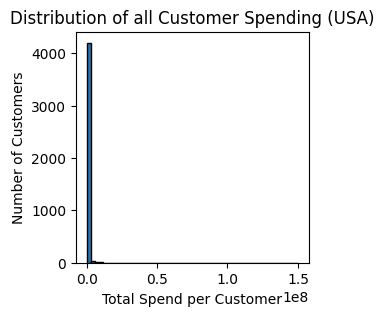

In [ ]:
# Calculate the total amount spent by each customer in the USA and for transactions made from home in the USA
user_totals = country_dfs['USA'].groupby('customer_id')['amount'].sum()

plt.figure(figsize=(3, 3))
plt.hist(user_totals, bins=50, edgecolor='black')
plt.xlabel('Total Spend per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of all Customer Spending (USA)')
plt.show()

The histogram of all customer spending in the USA shows a highly uneven distribution, where most customers have relatively low total spending compared to a few with extremely high spending values. The data is extremely right-skewed, indicating that a small number of outliers spend vastly more than the rest. These outliers stretch the scale, making the majority of customer spending appear concentrated near zero. This suggests that while most customers contribute modestly to total sales, a very small group of high spenders has a disproportionate impact on overall revenue.

### Drop customers greater than 75th percentile

In [ ]:
# Calculate the 75th percentile of total spend for each country and filter out customers above that threshold
for country in country_dfs:
    customer_totals = country_dfs[country].groupby('customer_id')['amount'].sum()
    percentile_75 = customer_totals.quantile(0.75)

    customers_to_drop = customer_totals[customer_totals > percentile_75].index

    country_dfs[country] = country_dfs[country][~country_dfs[country]['customer_id'].isin(customers_to_drop)]

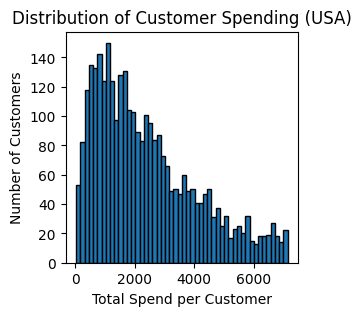

In [ ]:
# Calculate the total amount spent by each customer in the USA and for transactions made from home in the USA after filtering out high spenders
user_totals = country_dfs['USA'].groupby('customer_id')['amount'].sum()

plt.figure(figsize=(3, 3))
plt.hist(user_totals, bins=50, edgecolor='black')
plt.xlabel('Total Spend per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Spending (USA)')
plt.show()

After removing customers whose spending was above the 75th percentile, the updated histogram shows a much more balanced and realistic distribution of customer spending in the USA. Unlike the earlier version, which was heavily right-skewed due to a few extremely high spenders, this graph presents a clearer picture of typical customer behavior. Most customers now fall within a moderate spending range—roughly between $500 and $2,000—with a gradual decline toward higher spending levels. This adjustment reduces the impact of outliers and highlights the core spending pattern of the majority of customers, making the distribution more even and representative of the general customer base.

# JSON

Nested loop to build a JSON-style dictionary

In [ ]:
# Create a JSON structure to store the aggregated data for each country and user
json_dict = {}

for country, df_country in country_dfs.items():
    json_dict[country] = {
        'country_aggregate_data': {
            'Currency': country_to_currency[country],
            'Categories': {}
        },
        'users': {}
    }

    for category in df_country['merchant_category'].unique():
        df_cat = df_country[df_country['merchant_category'] == category]

        # num_users = df_cat['customer_id'].nunique()
        total_spent = df_cat['amount'].sum()
        mean_per_single_transaction = df_cat['amount'].mean() if len(df_cat) > 0 else 0

        mean_monthly_total = df_cat.groupby('customer_id')['amount'].sum().mean()  # we need to sum all the transactions
        med_monthly_total = df_cat.groupby('customer_id')['amount'].sum().median()   # within each customerm for their own month total
        std = df_cat.groupby('customer_id')['amount'].sum().std()                  #THEN find the mean, med mode

        json_dict[country]['country_aggregate_data']['Categories'][category] = {
            'total_spent': total_spent,
            'mean_per_single_transaction': mean_per_single_transaction,
            'median_per_single_transaction': df_cat['amount'].median() if len(df_cat) > 0 else 0,
            'med_monthly_total': med_monthly_total,
            'category_std': std,
            'avg_spending_per_user': mean_monthly_total
        }

    for user in df_country['customer_id'].unique():
        customer_data = df_country[df_country['customer_id'] == user]
        total_user_spending = customer_data['amount'].sum()

        json_dict[country]['users'][user] = {
            'total_spending': total_user_spending,
            'categories': {}
        }

        for category in df_country['merchant_category'].unique():

            cat_sub_df = customer_data[customer_data['merchant_category'] == category]

            # national_cat_data = json_dict[country]['country_aggregate_data']['Categories'][category]
            # avg_per_user = national_cat_data['avg_spending_per_user']
            # cat_std = national_cat_data['category_std']

            national_cat_std = json_dict[country]['country_aggregate_data']["Categories"][category]['category_std']
            national_cat_mean = json_dict[country]['country_aggregate_data']["Categories"][category]['avg_spending_per_user']

            if len(cat_sub_df) > 0:
                highest_tx = cat_sub_df.loc[cat_sub_df['amount'].idxmax(), ['amount', 'merchant_type', 'merchant','date_transact']].to_dict()
                cat_total = cat_sub_df['amount'].sum()
                #cat_mean = cat_sub_df['amount'].mean()
            else:
                highest_tx = None
                cat_total = 0
                #cat_mean = 0

            # Z-score: handle zero std
            # cat_zscore = (cat_mean - national_cat_data['mean_per_transaction']) / cat_std if cat_std > 0 else 0
            cat_zscore = (cat_total - national_cat_mean) / national_cat_std if national_cat_std > 0 else 0

            # Over benchmark: user total vs average per user
            cat_over_benchmark = bool(cat_total >= 1.5 * national_cat_mean) if national_cat_mean > 0 else False

            json_dict[country]['users'][user]['categories'][category] = {
                'total_cat_spending': cat_total,
                'highest_transaction': highest_tx,
                'cat_zscore': cat_zscore,
                'cat_over_benchmark': cat_over_benchmark
            }

We aggregated the transaction data into a JSON structure for each country. At the country level, we store metrics for each merchant category (total spent, median, standard deviation, and average spending per user). At the user level, we track each user’s total spending, spending per category, their largest transaction, how far their category spending deviates from the country average (z-score), and whether their spending exceeds a benchmark (1.5× the average). This structure allows easy comparison between users and country-level trends while supporting further analysis in the budgeting app

### JSON (one country preview)



In [ ]:
# Create a JSON structure to store the aggregated data for each country and user
def limit_depth(obj, max_depth, current_depth=0):
    """Recursively limit the depth of nested structures"""
    if current_depth >= max_depth:
        return "..." if isinstance(obj, (dict, list)) else obj

    if isinstance(obj, dict):
        return {k: limit_depth(v, max_depth, current_depth + 1)
                for k, v in list(obj.items())[:7]}  # limit to 7 items
    elif isinstance(obj, list):
        return [limit_depth(item, max_depth, current_depth + 1)
                for item in obj[:7]]  # Limit to 7 items
    else:
        return obj

# Show structure with limited depth
preview = limit_depth(json_dict['USA'], max_depth=6)
print(json.dumps(preview, indent=2))

{
  "country_aggregate_data": {
    "Currency": "USD",
    "Categories": {
      "Restaurant": {
        "total_spent": 607770.5484024566,
        "mean_per_single_transaction": 358.5666952226882,
        "median_per_single_transaction": 259.10926365795723,
        "med_monthly_total": 344.71496437054634,
        "category_std": 502.17880270264754,
        "avg_spending_per_user": 475.9362164467163
      },
      "Healthcare": {
        "total_spent": 953757.9124377882,
        "mean_per_single_transaction": 556.776364528773,
        "median_per_single_transaction": 502.44655581947745,
        "med_monthly_total": 565.249406175772,
        "category_std": 586.4524558605123,
        "avg_spending_per_user": 731.9707693306126
      },
      "Gas": {
        "total_spent": 972536.5223998702,
        "mean_per_single_transaction": 551.9503532348866,
        "median_per_single_transaction": 501.73396674584325,
        "med_monthly_total": 571.9714964370546,
        "category_std": 578.30616

We previewed the aggregated JSON for a single country (USA) while limiting its depth and the number of items displayed. This helps quickly inspect the structure—country-level aggregates, user-level spending, and category metrics—without overwhelming output from all users and categories.

## JSON Exporting

In [ ]:
# Save the JSON structure to a file in Google Drive
from google.colab import drive

# Mount drive if not already mounted
drive.mount('/content/drive', force_remount=True)

# Write directly to file without printing
output_path = '/content/drive/MyDrive/nov_code_jam_outputs/all_countries_user_data.json'
with open(output_path, 'w') as f:
    json.dump(json_dict, f, indent=4)

print(f"Saved to {output_path}")

Mounted at /content/drive
Saved to /content/drive/MyDrive/nov_code_jam_outputs/all_countries_user_data.json


In [53]:
# Mount drive if not already mounted
drive.mount('/content/drive', force_remount=True)

countries_to_export = ['USA']
subset = {country: json_dict[country] for country in countries_to_export if country in json_dict}

# Write directly to file without printing
output_path = '/content/drive/MyDrive/nov_code_jam_outputs/one_country_preview.json'
with open(output_path, 'w') as f:
    json.dump(subset, f, indent=4)

print(f"Saved to {output_path}")

Mounted at /content/drive
Saved to /content/drive/MyDrive/nov_code_jam_outputs/one_country_preview.json


In [ ]:
# Mount drive if not already mounted
drive.mount('/content/drive', force_remount=True)

countries_to_export = ['Mexico', 'USA', 'Canada']
subset = {country: json_dict[country] for country in countries_to_export if country in json_dict}

# Write directly to file without printing
output_path = '/content/drive/MyDrive/nov_code_jam_outputs/north_america_user_data.json'
with open(output_path, 'w') as f:
    json.dump(subset, f, indent=4)

print(f"Saved to {output_path}")

Mounted at /content/drive
Saved to /content/drive/MyDrive/nov_code_jam_outputs/north_america_user_data.json


We exported the aggregated JSON data to Google Drive in multiple versions:

1. All countries – complete dataset for every user and category.
2. Single-country preview (USA) – useful for quick inspection or testing.
3. North America subset (Mexico, USA, Canada) – focused regional dataset for targeted analysis.

This ensures the data is safely stored and accessible for downstream use or sharing.

# Visualization

In [ ]:
# Function to plot all visuals for a given country and user
def plot_all_visuals(country, user_id, data):
  agg_data = data[country]['country_aggregate_data']
  user_data = data[country]['users'][user_id]

  categories = list(agg_data["Categories"].keys())

  df_compare = pd.DataFrame({
      "category": categories,
      "user_spending": [
          user_data["categories"].get(cat, {}).get("total_cat_spending", 0) for cat in categories
      ],
      "avg_spending": [
           agg_data["Categories"][cat]["avg_spending_per_user"] for cat in categories
      ],
      "over_benchmark": [
            user_data["categories"].get(cat, {}).get("cat_over_benchmark", False) for cat in categories
      ]
  })

  plt.figure(figsize=(10,5))
  plt.bar(df_compare["category"], df_compare["avg_spending"], label="Average User")
  plt.bar(df_compare["category"], df_compare["user_spending"], alpha=0.7, label="User")
  plt.xticks(rotation=45)
  plt.ylabel("Spending")
  plt.title(f"{user_id} in {country}: User vs Average per Category")
  plt.legend()
  plt.show()

  df_outliers = df_compare[df_compare["over_benchmark"] == True]
  if not df_outliers.empty:
      plt.figure(figsize=(3,3))
      plt.bar(df_outliers["category"], df_outliers["user_spending"], color='orange')
      plt.ylabel("Spending")
      plt.title(f"{user_id} — Categories >1.5× Avg")
      plt.show()
  else:
      print(f"No outlier categories for {user_id} in {country}.")

  plt.figure(figsize=(7,7))
  plt.pie(
      df_compare["user_spending"],
      labels=df_compare["category"],
      autopct="%1.1f%%",
      startangle=90
  )
  plt.title(f"{user_id} — Spending Distribution by Category")
  plt.show()

This function generates a set of visualizations for a given country and user:

1. Bar chart: Compares the user’s spending per category to the average spending of all users in that country.

2. Outlier bar chart: Highlights categories where the user’s spending exceeds 1.5× the average (if any).

3. Pie chart: Shows the user’s spending distribution across categories, providing a quick overview of where money is allocated.

It makes it easy to spot overspending or unusual patterns for individual users.

### Load User Data JSON

In [ ]:
# Example usage:
with open('/content/drive/MyDrive/nov_code_jam_outputs/all_countries_user_data.json') as f:
    data = json.load(f)

### `CUST_49524`

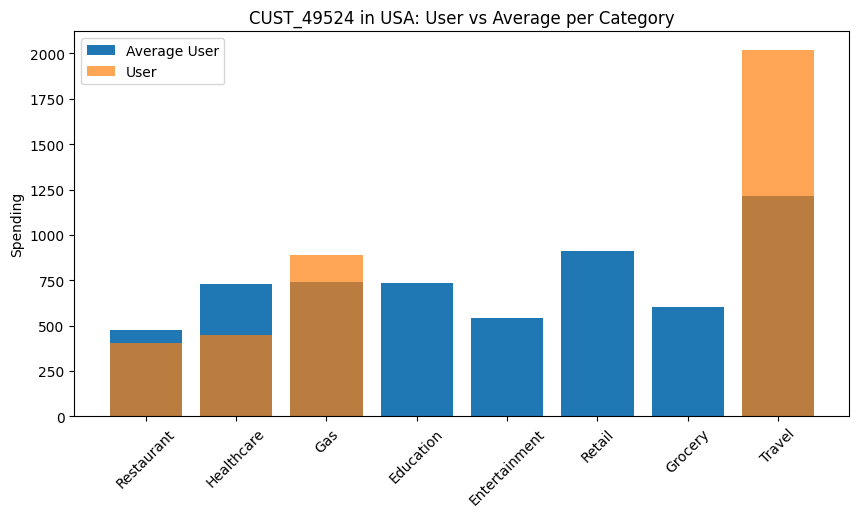

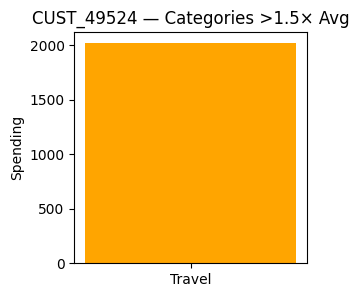

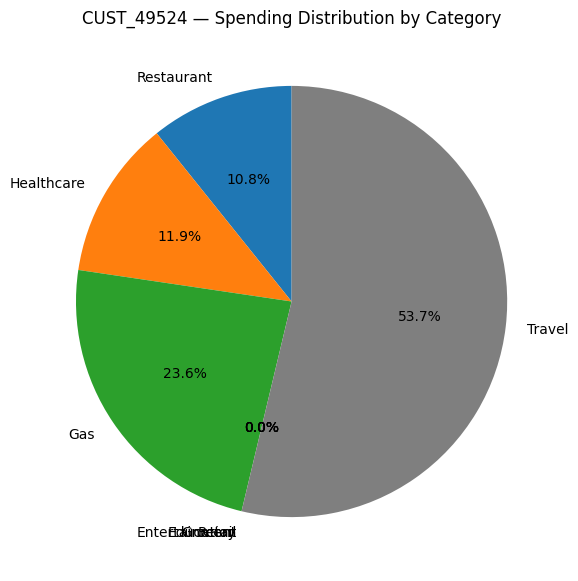

In [ ]:
# Plot all visuals for a user 'CUST_49524' in the USA
plot_all_visuals(country="USA", user_id="CUST_49524", data=data)

Observations:

**1. Category Spending vs Average User**

- The user’s spending is highest in Travel, significantly above the average user (~1.5× or more).
- Gas spending is slightly above the average, while other categories (Restaurant, Healthcare, Education, Entertainment, Retail, Grocery) are below or near average.

**2. Outlier Categories**

- Travel is the only category where this user exceeds 1.5× the average user’s spending.
- This suggests a heavy preference or requirement for travel compared to typical spending patterns.

**3. Spending Distribution**

- Travel dominates the user’s spending (~54% of total expenses).
- Gas accounts for ~24%, Healthcare ~12%, and Restaurant ~11%.
- Other categories contribute negligibly (<1%), indicating focused spending priorities.

Conclusion:

`CUST_49524` is a **travel-heavy spender**, with most other expenses remaining modest relative to average users. This behavior may reflect frequent travel for work, leisure, or other obligations. Categories like Retail, Grocery, Entertainment, and Education have minimal financial impact for this user.

### `CUST_73030`

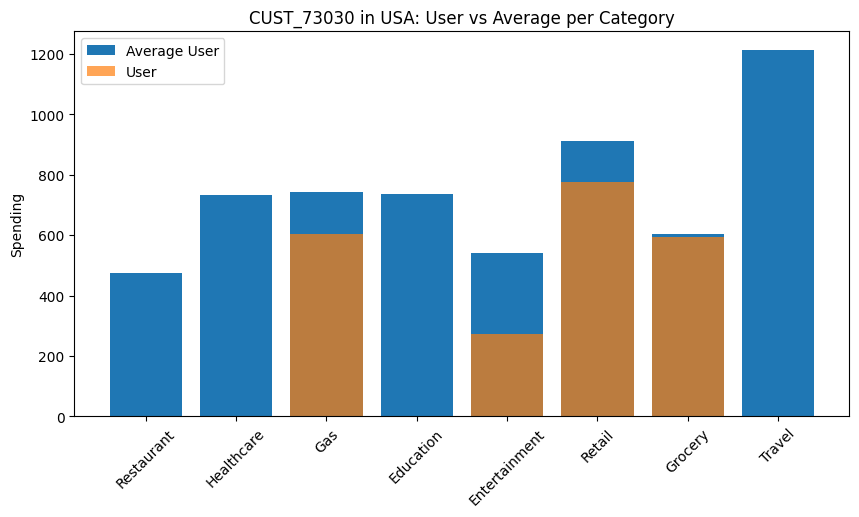

No outlier categories for CUST_73030 in USA.


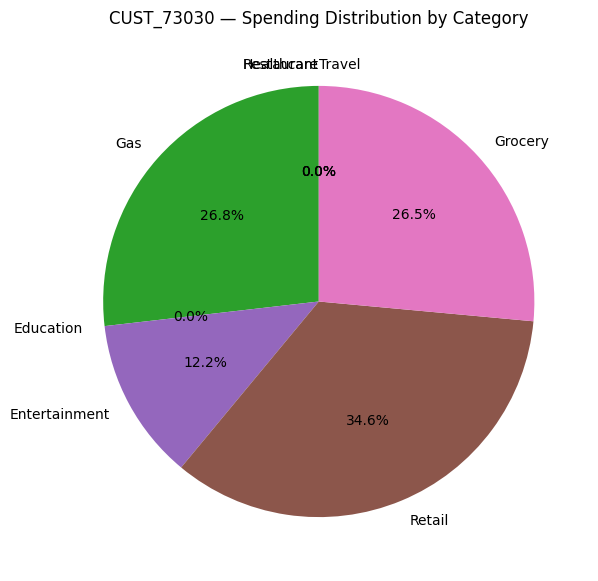

In [ ]:
# Plot all visuals for a user 'CUST_73030' in the USA
plot_all_visuals(country="USA", user_id="CUST_73030", data=data)

Observations:

**1. Category Spending vs Average User**

- The user’s overall spending is generally below or close to the average across most categories.
- Noticeably, Retail, Grocery, and Gas are the primary spending areas, with user amounts reaching near-average levels.
- Categories like Restaurant, Healthcare, Education, and Travel show no or minimal spending, indicating low engagement in these areas.
- Entertainment spending is modest compared to average user trends.

**2. Outlier Categories**

- There are no outlier categories for this user, as spending in each category remains within normal variation (<1.5× or >0.5× of the average).
- The user maintains a balanced pattern without any category showing excessive or unusually low spending relative to peers.

**3. Spending Distribution**

- Retail (34.6%), Gas (26.8%), and Grocery (26.5%) dominate the user’s total expenditures.
- Entertainment (12.2%) is a secondary spending area.
- Restaurant, Healthcare, Education, and Travel account for negligible portions of total spending, indicating selective category engagement.

Conclusion

`CUST_73030` exhibits a practical and focused spending profile, concentrating mainly on essential and lifestyle categories such as Retail, Gas, and Grocery. The absence of significant outliers suggests a steady and moderate spending behavior, with limited discretionary spending in areas like Travel or Dining. This pattern reflects a balanced consumer profile with predictable spending habits.

## Future Improvements

- Integration of Real-World Data:
    - Replace synthetic datasets with verified real-world transaction data to enhance the accuracy and reliability of spending benchmarks.
- Dynamic Currency Conversion:
    - Implement real-time currency exchange rate updates to reflect daily fluctuations instead of relying on fixed monthly averages.
- Expanded Timeframes:
    - Extend the analysis beyond a single month to capture seasonal or long-term spending trends.
- Enhanced Outlier Detection:
    - Use advanced statistical or machine learning methods to detect and manage anomalies more effectively rather than relying solely on percentile-based filtering.
- Demographic and Behavioral Segmentation:
    - Incorporate demographic attributes (age, income, region) and behavioral features to build richer, more personalized spending insights.
- Automated Data Pipeline:
    - Develop a continuous ETL (Extract, Transform, Load) pipeline to automate data ingestion, cleaning, and export for seamless integration with the Smart Budget Planner frontend.

## Conclusion

The project was designed to prepare, clean, and analyze international credit card transaction data to support the development of the Smart Budget Planner — a collaborative budgeting application that helps users understand and manage their spending patterns in comparison to national averages. The overarching goal was to transform raw transactional data into structured, high-quality insights suitable for integration into the app’s backend, bridging the gap between data science and software engineering.

This project successfully transformed multi-country transaction records into a reliable and insightful dataset through a series of robust data preprocessing and analytical steps. Key operations included standardizing currencies, normalizing timestamps, removing fraudulent and irrelevant records, and correcting mislabeled geographic indicators (distance_from_home). To ensure the spending patterns reflected realistic consumer behavior, users with extreme spending above the 75th percentile were also removed. These processes significantly improved the dataset’s accuracy, consistency, and interpretability.

The final cleaned and aggregated dataset provides a solid foundation for analyzing both national and individual spending trends. By structuring the outputs into country-level and user-level JSON files, the data can now be directly leveraged by the Smart Budget Planner to benchmark users against national averages and provide personalized spending insights. This enables the app to promote financial literacy, highlight areas of overspending, and help users make more informed budgeting decisions.

Beyond technical achievements, the project demonstrates the power of data-driven personalization — transforming raw financial data into meaningful, user-centric insights. With this foundation, the Smart Budget Planner can visualize category-level spending, identify outlier behavior, and deliver targeted recommendations that empower users to take control of their finances.

Overall, this project establishes a solid analytical and data-engineering framework that can be expanded and refined to deliver even deeper, more actionable financial insights in future iterations.